In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import mltools

In [2]:
train_iter, val_iter, test_iter, vocab = mltools.chn_senti_corp('../data/ChnSentiCorp_htl_all.csv')  # 加载词表，数据集
rnn_layer = nn.LSTM(len(vocab), hidden_size=512, batch_first=True, bidirectional=True)  # 定义循环网络LSTM
model = mltools.RNNCModel(lambda x: F.one_hot(x, len(vocab)), rnn_layer, output_size=2)  # 定义训练模型
device = torch.device('cuda')


class LSTMCSC(mltools.RNNTXTCLearning):
    def show_pred(self, contents, preds, reals):
        for content, pred, real in zip(contents, preds, reals):
            print(f'预测值 {pred}, 真实值 {real}, 数据 {''.join(vocab[content.tolist()]).replace('<pad>', ' ')}')


ml = LSTMCSC(model, train_iter, val_iter, test_iter, device=device)

2025-05-22 21:25:07,048 - INFO: train loss 0.613, val loss 0.609, val acc 0.700, 39.6 sec/epoch on cuda


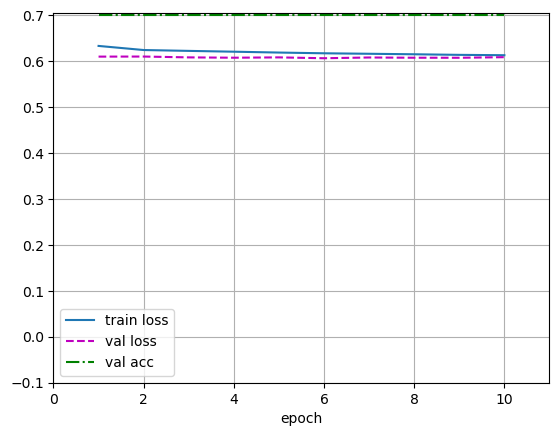

In [3]:
ml.set_loss(nn.CrossEntropyLoss())
ml.set_optimizer(optim.SGD(model.parameters(), lr=1e-1))
ml.train(num_epochs=10)  # 训练

In [4]:
ml.test()  # 测试

2025-05-22 21:25:10,520 - INFO: test acc 0.708


In [5]:
ml.predict()  # 预测

预测值 1, 真实值 1, 数据 网上定了个行政标间，还用信用卡担保的，到了后却被告知有客人没退房，改成了一般套间。但酒店还算可以，提供了免费上网和两个免费早餐。                                                                                                                                        
预测值 1, 真实值 0, 数据 游泳池不错,其他很一般,房间设施差,房间太小,不过价格很便宜,属于一般选择.                                                                                                                                                                  
预测值 1, 真实值 1, 数据 我常在外到出差,是我第一次入住,LOBBY小但感挺精的,度也不,房倒是很好,客大,房全,也可以免外借具,然用的不大,倒是予支持!房不大,但很乾!以我吹毛求疵的要求,整,店非常高的!但是有最大的缺就是地太偏了!到地王,象城要20到30元,而且很塞!叫出租要很久才有!住客要多注意!也希望酒店能跟出租公司配合,降低等!而言房可比五星,但外只能到四星,不是四星的位!可推大家!               
预测值 1, 真实值 1, 数据 服务，房间都很不错。交通也不错。酒店附近就有很多小饭店，都还不错的。12路公交一直到火车站，很方便。如果下次还去黄山的话肯定还住这家拉。                                                                                                                                    
预测值 1, 真实值 1, 数据 1、打车到宾馆和离开，送上登记出租车牌号的卡片，如有物品遗漏，便于查找；2、前台服务很快；3、在3楼中餐厅吃了两顿晚餐，口味蛮好，服务一流，主动引导入座便于观看电视的座位，方便收看奥运，早餐设有厦门小吃区有特色，无论晚餐还